# Example 2 - Tilt-calibrated compass

A magnetometer detects the local magnetic field in three axes relative to the sensor. Assuming there are no local magnetic disturbances, this magnetic field $\mathbf{B}$ points to the north magnetic pole (i.e. north and downwards in the northern hemisphere) with an absolute intensity in the UK around $48 \mu T$.

If the magnetometer is held flat relative to the ground, with the sensor pointing in the $X$ direction and the $Z$ (yaw) axis pointing straight down, the magnetic sensors in the $X$ and $Y$ directions read $B_x = B_h\cos\psi$ and $B_y = B_h\sin\psi$ respectively, where $B_h$ is the horizontal component of the magnetic field (around $18\mu T$ in UK). So the heading $\psi$ is given by:
$$\psi = \arctan\frac{B_y}{B_x}$$

Now if the sensor tilts down in the $X$ or the $Y$ directions by roll and pitch angles ($\phi$ and $\theta$ respectively), their magnetometer axes now pick up less of the horizontal flux but a portion of the vertical flux. If we use the raw values of $B_x$ and $B_y$, this corrupts the calculation of $\psi$.

To overcome this, at least when the sensor is still or moving steadily, we can use the accelerometer to measure the direction of  gravity. This gives us $\phi$ and $\theta$. Applying these as 3-d rotations gives corrected values for $B_y$ and $B_z$, hence a more accurate measurement of the heading $\psi$.


## Getting sensor data from BBC micro:bit

Use the same approach as example 1 to log BBC micro:bit motion sensor data to a csv text file on my local PC. With the local microbit in relay mode (displaying a heart), start logging data with:

   ```$ python usb-receiver.py > data-compass-heading-with-tilt.csv```

Set the remote microbit to transmitter mode (press button A until it displays a flashing right-pointing arrow, showing it is sending data). Now the receiver's LED heart should be flashing too.

Hold the microbit flat pointing ahead in an approximately constant heading. Slowly tilt it up and down gatering data for 20 seconds or so.

Stop the data collections by pressing Ctrl-C on the PC.

## Loading sensor data into a pandas DataFrame

Set up main numpy, pandas and matplotlib libraries:

In [184]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd
import math
rad2deg = 180.0 / math.pi
deg2rad = 1.0 / rad2deg

In [180]:
df = pd.read_csv('data-compass-heading-with-tilt.csv')
mag_cols = ['MagX','MagY','MagZ']
acc_cols = ['AccX','AccY','AccZ']
df['Time'] /= 1000.0    # Convert from ms (int) to sec (float)
df[acc_cols] /= 1000.0  # mG to G
df[mag_cols] /= 1000.0    # 0.1 nT to uT
df.set_index('Time', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 711 entries, 20.964 to 47.862
Data columns (total 8 columns):
AccX       711 non-null float64
AccY       711 non-null float64
AccZ       711 non-null float64
MagX       711 non-null float64
MagY       711 non-null float64
MagZ       711 non-null float64
Heading    711 non-null int64
Gesture    613 non-null object
dtypes: float64(6), int64(1), object(1)
memory usage: 50.0+ KB


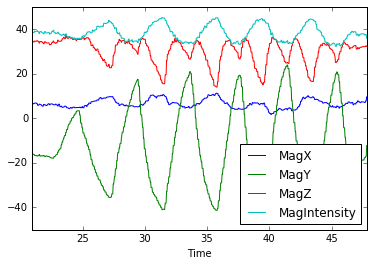

In [183]:
df['MagIntensity'] = df[mag_cols].pow(2).sum(axis=1).pow(0.5)
df[['MagX','MagY','MagZ','MagIntensity']].plot()

The simplest estimate of heading just ignores the yaw component and assumes the sensor is held flat and is not accelerating. 

Clearly this is not a great assumption... 

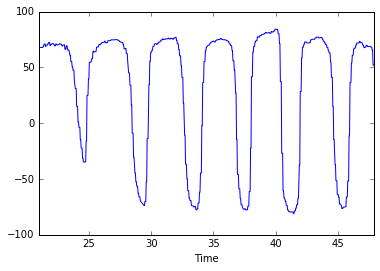

In [185]:
def compass_heading_simple(df):
    """Pandas series with simple compass heading in degrees.
    
    Assumes magnetometer is held flat and still, 
    parallel to the Earth's magnetic field
    
    df      - DataFrame with cols MagX and MagY
    """
    mx, my, mz = df.MagX, df.MagY, df.MagZ
    psi = np.arctan2(-my, mx)
    s = pd.Series( psi*rad2deg, index=df.index, name='SimpleHeading')
    return s

heading_simple = compass_heading_simple(df)
heading_simple.plot()

Here is the corresponding acceleration as I tilted the Microbit up and down in a vertical plane while keeping approximately the same forward heading. I tried to keep it still in the $X$ direction. When not tilting, the $Z$ acceleration is around -1000 mG, in other words a downward acceleration due to gravity of $9.81 m/s^2$.

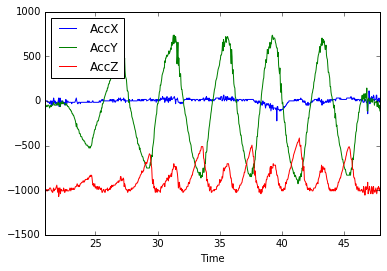

In [186]:
hwt_df[['AccX','AccY','AccZ']].plot()

(Note that +ve Z for the accelerometer is up, while +ve Z for the magnetometer is down)

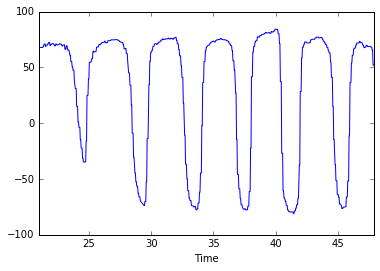

In [99]:
rad2deg = 180.0 / math.pi
deg2rad = 1 / rad2deg

def compass_heading_simple(df):
    """Pandas series with simple compass heading in degrees.
    
    Assumes magnetometer is held flat and still, 
    parallel to the Earth's magnetic field
    
    df      - DataFrame with cols MagX and MagY
    """
    mx, my, mz = df.MagX, df.MagY, df.MagZ
    psi = np.arctan2(-my, mx)
    s = pd.Series( psi*rad2deg, index=df.index, name='SimpleHeading')
    return s

heading_simple = compass_heading_simple(hwt_df)
heading_simple.plot()

I was standing facing approximately 70 degrees N as I tilted the Microbit. While the Microbit is flat, this is ok. But it is terribly inaccurate when tilted.

To overcome this, we need tilt compensation:

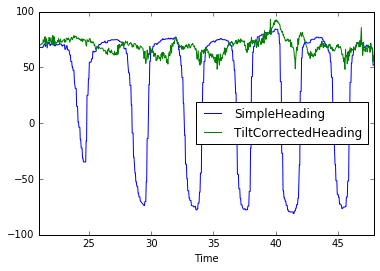

In [188]:
def compass_heading_tilt_comp(df):
    """Pandas series with compass heading corrected for tilt.
    
    This assumes the accelerometer is held still.
    From the angle of gravity, we infer the magnetometer's
    tilt relative to the Earth's surface. 
    We undo the effects of tilt in the roll and pitch
    directions, leaving a clean magnetic heading in
    the yaw (Z) direction.
    
    The input dataframe is assumed to have columns named
    MagX, MagY, MagZ, AccX, AccY, AccZ.
    """
    ax, ay, az = df.AccX, df.AccY, df.AccZ
    mx, my, mz = df.MagX, df.MagY, df.MagZ
    
    # Undo roll around X axis by angle phi
    phi = np.arctan2(ay, az)
    s, c = np.sin(phi), np.cos(phi)
    az = ay*s + az*c
    my, mz = (my*c - mz*s), (my*s + mz*c)
    
    # Undo pitch around Y axis by angle theta
    theta = np.arctan2(-ax, az)
    s, c = np.sin(theta), np.cos(theta)
    mx, mz = (mx*c + mz*s), (-mx*s + mz*c)
    
    # Calculate yaw angle psi around Z axis
    psi = np.arctan2(my, mx)
    s = pd.Series( psi*rad2deg, index=df.index, name='TiltCorrectedHeading')
    return s

heading_tc = compass_heading_tilt_comp(df)
res = pd.DataFrame([heading_simple, heading_tc]).T
res.plot()    

The result is pretty good, if noisy. A low-pass filter would help here.

# Correcting for "hard iron" and "soft iron" distortions

To illustrate the effects of miscalibration, I gathered 100 secs of data while slowly rotating the microbit on each of its 6 axis. The resulting magnetometer data $(M_x, M_y, M_z)$ should lie on a perfect sphere whose radius is the magnitude of the local magnetic field strength.

However because the sensor structure will contain some ferromagnetic materials, this sphere ends ups mis-centred (due to permanently magnetized "hard iron", vector $\mathbf{V}$) and more ellipsoid (due to induced fields in the nonpermanently magnetized "soft iron", matrix \mathbf{W}).

$$ \mathbf{B}_p = \mathbf{W}\mathbf{R}_\phi\mathbf{R}_\theta\mathbf{B}_\psi \mathbf{B}_r + \mathbf{V}$$

In [190]:
df = pd.read_csv('data-compass-calibration.csv')
df['Time'] /= 1000.0    # Convert from ms (int) to sec (float)
df.set_index('Time', inplace=True)
df[mag_cols] /= 1000.
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2701 entries, 6.834 to 106.842
Data columns (total 8 columns):
AccX       2701 non-null int64
AccY       2701 non-null int64
AccZ       2701 non-null int64
MagX       2701 non-null float64
MagY       2701 non-null float64
MagZ       2701 non-null float64
Heading    2701 non-null int64
Gesture    2673 non-null object
dtypes: float64(3), int64(4), object(1)
memory usage: 189.9+ KB


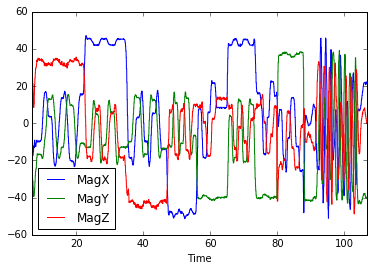

In [191]:
magXYZ = df[mag_cols]
magXYZ.plot()

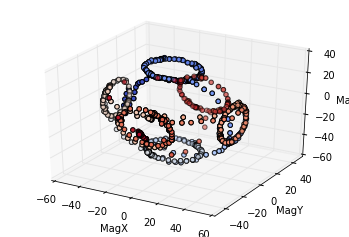

In [197]:
# Trim start and end to get data for calibration
def plotDataFrame3D(df):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter3D( df.ix[:,0], df.ix[:,1], df.ix[:,2], 
            c=np.linspace(0, 1, len(df)), cmap=plt.cm.coolwarm)
    ax.set_xlabel(df.columns[0])
    ax.set_ylabel(df.columns[1])
    ax.set_zlabel(df.columns[2])
    plt.show()
    
B = df[mag_cols][5.0:90.0]
plotDataFrame3D(B)

A simple estimate of the "hard iron" offset is from the midpoint of the extreme in all three axes:

In [198]:
V = (B.min() + B.max())/2
V

MagX   -2.122
MagY   -1.837
MagZ   -5.394
dtype: float64

A better calibration is to fit points to an ellipsoid.
Here is some code from https://github.com/minillinim/ellipsoid/blob/master/ellipsoid.py:

In [25]:
from numpy import linalg

def getMinVolEllipse(P=None, tolerance=0.01):
        """ Find the minimum volume ellipsoid which holds all the points
        
        Based on work by Nima Moshtagh
        http://www.mathworks.com/matlabcentral/fileexchange/9542
        and also by looking at:
        http://cctbx.sourceforge.net/current/python/scitbx.math.minimum_covering_ellipsoid.html
        Which is based on the first reference anyway!
        
        Here, P is a numpy array of N dimensional points like this:
        P = [[x,y,z,...], <-- one point per line
             [x,y,z,...],
             [x,y,z,...]]
        
        Returns:
        (center, radii, rotation)
        
        """
        (N, d) = np.shape(P)
        d = float(d)
    
        # Q will be our working array
        Q = np.vstack([np.copy(P.T), np.ones(N)]) 
        QT = Q.T
        
        # initializations
        err = 1.0 + tolerance
        u = (1.0 / N) * np.ones(N)

        # Khachiyan Algorithm
        while err > tolerance:
            V = np.dot(Q, np.dot(np.diag(u), QT))
            M = np.diag(np.dot(QT , np.dot(linalg.inv(V), Q)))    # M the diagonal vector of an NxN matrix
            j = np.argmax(M)
            maximum = M[j]
            step_size = (maximum - d - 1.0) / ((d + 1.0) * (maximum - 1.0))
            new_u = (1.0 - step_size) * u
            new_u[j] += step_size
            err = np.linalg.norm(new_u - u)
            u = new_u

        # center of the ellipse 
        center = np.dot(P.T, u)
    
        # the A matrix for the ellipse
        A = linalg.inv(
                       np.dot(P.T, np.dot(np.diag(u), P)) - 
                       np.array([[a * b for b in center] for a in center])
                       ) / d
                       
        # Get the values we'd like to return
        U, s, rotation = linalg.svd(A)
        radii = 1.0/np.sqrt(s)
        
        return (center, radii, rotation)


In [201]:
centre, scale, rotation = getMinVolEllipse(B)

In [202]:
centre

array([-2.56724959, -1.67295084, -5.06831403])

In [203]:
scale

array([ 40.378515  ,  43.37958857,  51.99372798])

In [204]:
rotation

array([[-0.32580171, -0.79476172, -0.51206158],
       [-0.10248495, -0.50873328,  0.85480248],
       [-0.93986706,  0.33097471,  0.08429506]])

Note: Code below here is still WIP! Need to get W from the centre/scale/rotation matrices....

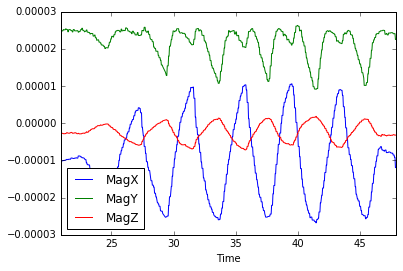

In [168]:
def calibrate_mag(magXYZ, V=centre, S=scale, R=rotation):
    # Hard iron correction
    magXYZ -= V
    # Rescale in rotated coordinates
    M = np.matmul(R, np.diag(1/S), np.linalg.inv(R))
    cal_magXYZ = np.matmul(magXYZ, M)
    return pd.DataFrame(cal_magXYZ, index=magXYZ.index, columns=magXYZ.columns)

a = hwt_df[['MagX','MagY','MagZ']]
calibrate_mag(a).plot()

In [45]:
centre

array([-2408.75223535, -1675.05904903, -6370.51870417])

In [50]:
mat = np.matrix(rotation)

In [52]:
np.linalg.inv(rotation)


array([[-0.38542067,  0.03925116, -0.92190577],
       [-0.84651775, -0.41265875,  0.33633383],
       [-0.36723099,  0.91003961,  0.19227402]])

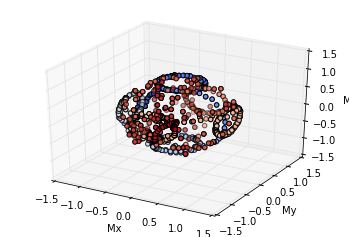

In [149]:
# B = W_soft_iron x Rot x B_earth + V
# x = np.matmul(B-V, np.linalg.inv(rotation))/radii
x = np.matmul(B-V, np.matmul(np.linalg.inv(rotation)/radii, rotation))
B_cal = pd.DataFrame(x, index=B.index, columns=['Mx','My','Mz'])
plotDataFrame3D(B_cal)

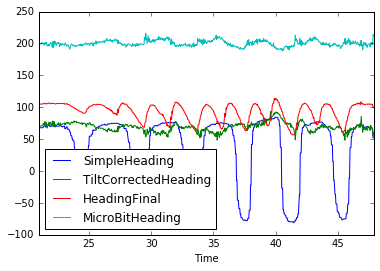

In [154]:
def compass_heading_final(df, W=rotation, V=centre, S=radii):
    """Pandas series with compass heading corrected for tilt.
    
    This assumes the accelerometer is held still.
    From the angle of gravity, we infer the magnetometer's
    tilt relative to the Earth's surface. 
    We undo the effects of tilt in the roll and pitch
    directions, leaving a clean magnetic heading in
    the yaw (Z) direction.
    
    The input dataframe is assumed to have columns named
    MagX, MagY, MagZ, AccX, AccY, AccZ.
    """
    magCols = ['MagX', 'MagY', 'MagZ']
    accCols = ['AccX', 'AccY', 'AccZ']
    df = df.copy()
    x = df[magCols] - V
    x = np.matmul(df[magCols] - V, rotation, np.diag(1/radii), np.linalg.inv(rotation)))
    df[magCols] = x
    #df[accCols] = np.matmul(df[accCols], np.linalg.inv(rotation).T)
    
    ax, ay, az = df.AccX, df.AccY, df.AccZ
    mx, my, mz = df.MagX, df.MagY, df.MagZ
    
    # Undo roll around X axis by angle phi
    phi = np.arctan2(ay, az)
    s, c = np.sin(phi), np.cos(phi)
    az = ay*s + az*c
    my, mz = (my*c - mz*s), (my*s + mz*c)
    
    # Undo pitch around Y axis by angle theta
    theta = np.arctan2(-ax, az)
    s, c = np.sin(theta), np.cos(theta)
    mx, mz = (mx*c + mz*s), (-mx*s + mz*c)
    
    # Calculate yaw angle psi around Z axis
    psi = np.arctan2(-mx, my)
    #psi[psi<0] += 360.0 * deg2rad
    return pd.Series(psi*rad2deg, index=df.index, name='HeadingFinal')
    
s = compass_heading_final(hwt_df)
res[s.name] = s
res['MicroBitHeading'] = hwt_df['Heading']
res.plot()
    

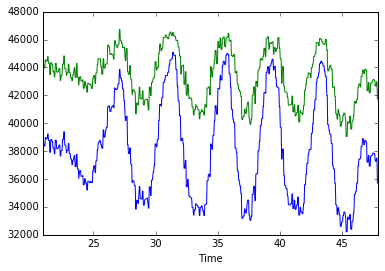

In [125]:
mag = hwt_df[['MagX', 'MagY', 'MagZ']]
mag_field_strength = mag.pow(2).sum(axis=1).pow(0.5)
mfs_calib_soft = (mag - V).pow(2).sum(axis=1).pow(0.5)
mfs_calib_hard = np.matmul(mag - V, rotation)